# Face Mask Detection

## Introduction

In the past few years, masks have played a crucial role in protecting individuals' health from respiratory diseases, as they are a very effective measure for preventing COVID-19 (Howard et al., 2021). Therefore, it is important to wear a mask properly in public places. This project will analyze each image in the dataset, detect the faces in the images and classify their mask-wearing (wearing correctly, wearing incorrectly, and not wearing a mask). Different models are used to detect and analyze the images in the dataset, find the best parameters for each model, compare them, and finally present the best model.

## Data Source

The dataset of this group project is from https://www.kaggle.com/datasets/andrewmvd/face-mask-detection . This dataset contains **853** images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format. Besides, each image has a unique annotation file corresponding to it which means there are **853** XML files originally. All the labels of each image accumulate to a total of **4,072** where there are **3,213** ‘with_mask’ labels, 717 ’without_mask’ labels and **123** ‘mask_weared_correct’ labels.

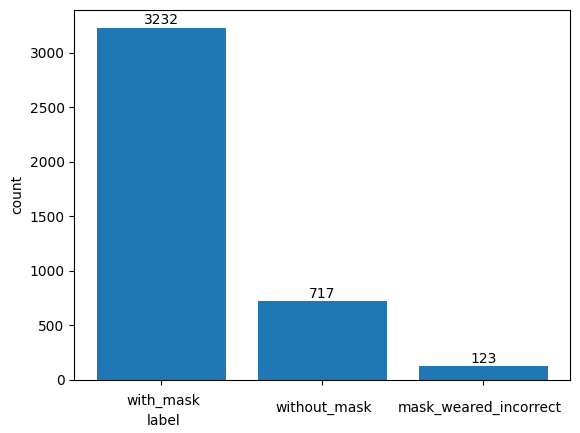

In [1]:
from IPython.display import Image
Image("./image/3.png")

The histogram shows that the number of labels in the data set is very unevenly distributed, so the final result should not be very good. We trained and tested the original dataset, and the results were as we expected, so we enhanced the dataset later.

In the process of training, parameters of the Faster R-CNN and YOLOv5 are both sets as follows: the default object confidence threshold was set as 0.25; the default IOU threshold for NMS was set as 0.45; the default image size was 640.

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
import shutil
import xml.etree.cElementTree as ET
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
from timeit import default_timer as timer
import torch
from timeit import default_timer as timer
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import image as mpimg
from matplotlib import patches as mpatches
from sklearn.model_selection import train_test_split
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import urllib
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import random
import time
import requests
import pickle
from os import getcwd
import imgaug as ia
from imgaug import augmenters as iaa

## Exploratory Data Analysis

### Show Example Image

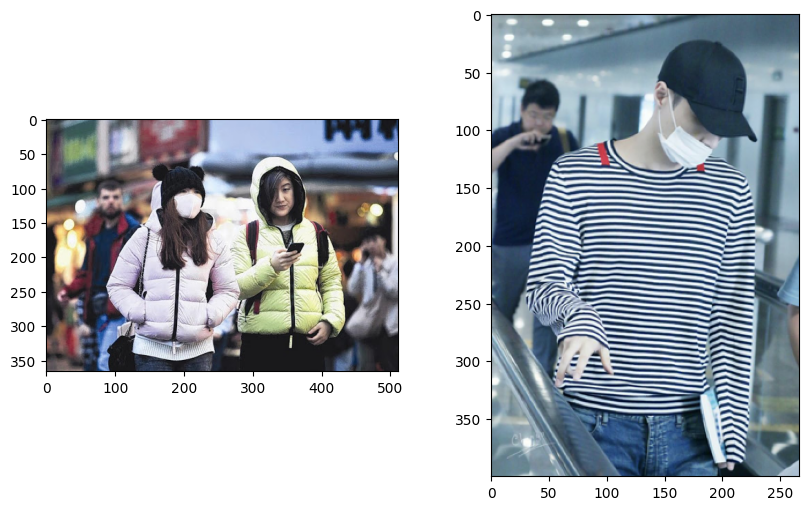

In [36]:
plt.figure(figsize = (10,6))
example_image_path = "./images/maksssksksss0.png"
image = cv2.imread(example_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(image_rgb);
example_image_path1 = "./images/maksssksksss9.png"
image1 = cv2.imread(example_image_path1)
image_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.imshow(image_rgb1);

### Draw Bounding Boxes

In this dataset, each image has an annotation corresponding to it, and we extract the coordinate value of the box from the annotation.

In [37]:
tree = ET.parse("./annotations/maksssksksss5.xml")
root = tree.getroot()
for i in root:
    if i.find("bndbox") != None:
            i.find("name").text

'with_mask'

'without_mask'

'without_mask'

'with_mask'

In [49]:
def draw_boxes(xml_path, image_path):
    image = cv2.imread(image_path)
    tree = ET.parse(xml_path)
    root = tree.getroot()  
    bnd_boxes = []
    for i in root:
        if i.find("bndbox") != None:
            bnd_box = []
            for j in list(i.find("bndbox")):
                bnd_box.append(int(j.text))
            bnd_box.append(i.find("name").text)
            bnd_boxes.append(bnd_box)
    for image_info in bnd_boxes:
        xmin = image_info[0]
        ymin = image_info[1] 
        xmax = image_info[2]
        ymax = image_info[3]
        name = image_info[4]
        if name == 'without_mask':
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 2)
        if name == 'with_mask':
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
        if name == 'mask_weared_incorrect':
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
    return image

In [50]:
exp_xml = "./annotations/maksssksksss0.xml"
exp_image = example_image_path
exp_xml1 = "./annotations/maksssksksss9.xml"
exp_image = example_image_path1
exp_image = draw_boxes(exp_xml, example_image_path)
exp_image1 = draw_boxes(exp_xml1, example_image_path1)

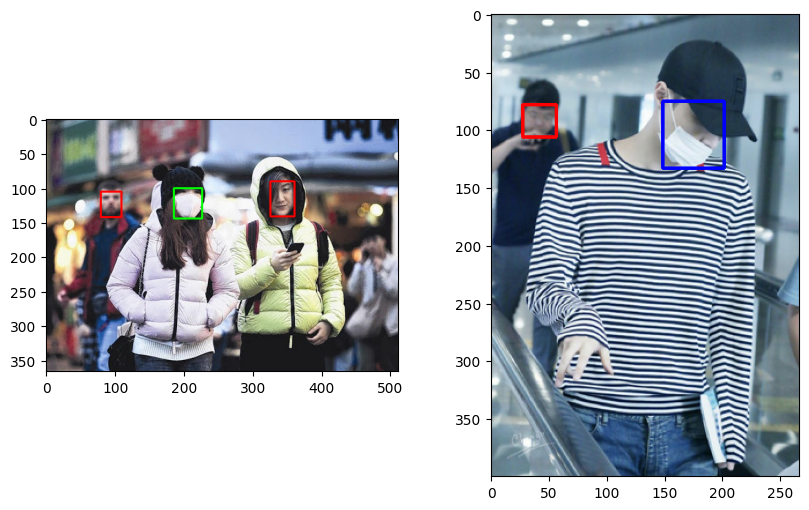

In [51]:
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
exp_image_rgb = cv2.cvtColor(exp_image, cv2.COLOR_BGR2RGB)
plt.imshow(exp_image_rgb);
plt.subplot(1,2,2)
exp_image_rgb1 = cv2.cvtColor(exp_image1, cv2.COLOR_BGR2RGB)
plt.imshow(exp_image_rgb1);

### Count Labels

In [52]:
def label_count(data_src_path):
    label_count_dict = defaultdict(int)
    for i in list(os.walk(data_src_path))[0][2]:
        emp_xml = data_src_path + i
        tree = ET.parse(emp_xml)
        root = tree.getroot()
        for i in root:
            if i.find('name') != None:
                if i.find('name').text == "without_mask":
                    label_count_dict["without_mask"] += 1
                if i.find('name').text == "with_mask":
                    label_count_dict["with_mask"] += 1
                if i.find('name').text == "mask_weared_incorrect":
                    label_count_dict["mask_weared_incorrect"] += 1
    return label_count_dict

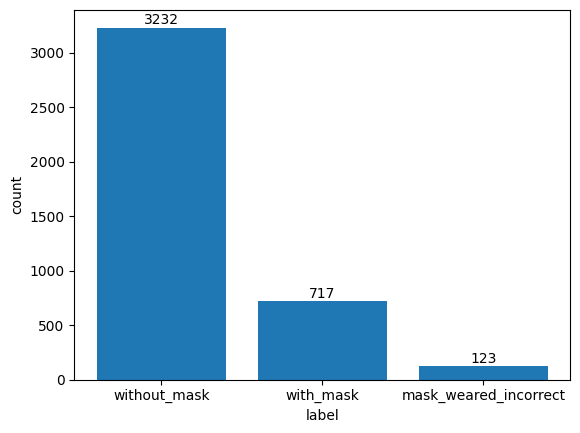

In [53]:
count_dict = label_count("./annotations/")
nums = [count_dict['with_mask'],count_dict['without_mask'], count_dict['mask_weared_incorrect']]
plt.bar(x=count_dict.keys(),height=nums)
x = range(0, len(nums))
for a, b in zip(x, nums):
    plt.text(a, b + 2, b, ha='center', va='bottom')
plt.xlabel("label")
plt.ylabel("count")
plt.show();

## Data Augmentation

### Read the Oringinal Dataset

In [ ]:
# path of images directory
dir_path = '../face-mask-detection/pure/images/'
# path of xml files directory
xml_path = '../face-mask-detection/pure/annotations/'
# List of Image file name 
file_list = os.listdir(dir_path)
# How many image files?
print('There are total {} images.'.format(len(file_list)))

### Create 2 Helper Functions

1. The first function is used for read the data from XML file.

2. The second function is used for drawing bounding boxes.

In [ ]:
# Helper function for read the data (label and bounding boxes) from xml file 
def read_annot(file_name, xml_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels    with_mask-->2   no_mask-->1
    """
    bbox = []
    labels = []
    # Each image has a unique annotation corresponding to it
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        elif label == 'mask_weared_incorrect':
            label_idx = 1
        else:
            label_idx = 0
        labels.append(label_idx)
        
    return bbox, labels

# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=1):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:  
            color = (0,225,0) # green
        elif label == 1:
            color = (0,255,255) # yellow
        else:
            color = (0,0,255) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Put the images that should be enhanced into the list spcial_image_list according to our needs.

In [ ]:
special_image_list = list()
for image in file_list:
    boxes, labels = read_annot(image, xml_path)
    if 1 in labels:
        special_image_list.append(image)
len(special_image_list)

Install the relevant data package for augmentation.

In [ ]:
%pip install six numpy scipy matplotlib scikit-image opencv-python imageio -i https://pypi.douban.com/simple/

In [ ]:
%pip install imgaug -i https://pypi.douban.com/simple/

In [ ]:
ia.seed(1)

def read_xml_annotation(root, image_id):
    in_file = open(os.path.join(root, image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()
    bndboxlist = []

    for object in root.findall('object'):  
        bndbox = object.find('bndbox')  # 

        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)
        # print(xmin,ymin,xmax,ymax)
        bndboxlist.append([xmin,ymin,xmax,ymax])
        # print(bndboxlist)

    bndbox = root.find('object').find('bndbox')
    return bndboxlist
# (506.0000, 330.0000, 528.0000, 348.0000) -> (520.4747, 381.5080, 540.5596, 398.6603)
def change_xml_annotation(root, image_id, new_target):
    new_xmin = new_target[0]
    new_ymin = new_target[1]
    new_xmax = new_target[2]
    new_ymax = new_target[3]

    in_file = open(os.path.join(root, str(image_id) + '.xml'))  # 这里root分别由两个意思
    tree = ET.parse(in_file)
    xmlroot = tree.getroot()
    object = xmlroot.find('object')
    bndbox = object.find('bndbox')
    xmin = bndbox.find('xmin')
    xmin.text = str(new_xmin)
    ymin = bndbox.find('ymin')
    ymin.text = str(new_ymin)
    xmax = bndbox.find('xmax')
    xmax.text = str(new_xmax)
    ymax = bndbox.find('ymax')
    ymax.text = str(new_ymax)
    tree.write(os.path.join(root, str(image_id) + "_aug" + '.xml'))

def change_xml_list_annotation(root, image_id, new_target,saveroot,id):

    in_file = open(os.path.join(root, str(image_id) + '.xml'))  
    tree = ET.parse(in_file)
    xmlroot = tree.getroot()
    index = 0

    for object in xmlroot.findall('object'):  
        bndbox = object.find('bndbox')  

        # xmin = int(bndbox.find('xmin').text)
        # xmax = int(bndbox.find('xmax').text)
        # ymin = int(bndbox.find('ymin').text)
        # ymax = int(bndbox.find('ymax').text)

        new_xmin = new_target[index][0]
        new_ymin = new_target[index][1]
        new_xmax = new_target[index][2]
        new_ymax = new_target[index][3]

        xmin = bndbox.find('xmin')
        xmin.text = str(new_xmin)
        ymin = bndbox.find('ymin')
        ymin.text = str(new_ymin)
        xmax = bndbox.find('xmax')
        xmax.text = str(new_xmax)
        ymax = bndbox.find('ymax')
        ymax.text = str(new_ymax)

        index = index + 1

    tree.write(os.path.join(saveroot, str(image_id) + "_aug_" + str(id) + '.xml'))

# Setting up storage paths for enhanced datasets
def mkdir(path):
    path = path.strip()
    path = path.rstrip("\\")
    isExists = os.path.exists(path)
    # If the path does not exist, create a new folder
    if not isExists:
        os.makedirs(path)
        print(path + ' building success')
        return True
    else:
        print(path + ' already exist')
        return False

### The Main Part for Data Augmentation

For the original data set, we first filtered out the images that only have 'green boxes' (green box means wear_mask class) and the number of green boxes greater than or equal to 5, and removed 50 such images at random, and this behavior significantly reduces the number of green boxes in the dataset.

Then, we enhanced the image containing the 'yellow box' (yellow box means incorrect_weared class). By using the relevant API, the original image is randomly rotated, enlarged, reduced, blurred, sharpened, etc., and the final image containing the yellow box becomes two times the original quantity.

Eventually, the number of images with 'red boxes' (red box means not_wearing class) was enhanced by the same process to twice the original number.

In [ ]:
IMG_DIR = '../face-mask-detection/oringinal/images/'
XML_DIR = '../face-mask-detection/oringinal/annotations/'

AUG_XML_DIR = '../face-mask-detection/archive/AUG_xml'  # the path for augmented xml file
mkdir(AUG_XML_DIR)

AUG_IMG_DIR = '../face-mask-detection/archive/AUG_image'  # the path for augmented png file
mkdir(AUG_IMG_DIR)

AUGLOOP = 1 # the number of the augmentation

boxes_img_aug_list = []
new_bndbox = []
new_bndbox_list = []


# augmentation part
seq = iaa.Sequential([
    iaa.Flipud(0.5),  # vertically flip 20% of all images
    iaa.Fliplr(0.5),  # mirror
    iaa.Multiply((1.2, 1.5)),  # change brightness, doesn't affect BBs
    iaa.GaussianBlur(sigma=(0, 3.0)), # Gaussian noise
    iaa.Affine(
        translate_px={"x": 15, "y": 15},
        scale=(0.8, 0.95),
        rotate=(-30, 30)
    )  # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

for root, sub_folders, files in os.walk(XML_DIR): #Iterate through all the images in the folder, 'file' represents the full name of each image

    for name in files:
        if (name[:-4] + '.png') in special_image_list:

            bndbox = read_xml_annotation(XML_DIR, name)

            for epoch in range(AUGLOOP):
                seq_det = seq.to_deterministic()  # not random, keep  the coordinate values constant
                # read the image
                img = Image.open(os.path.join(IMG_DIR, name[:-4] + '.png'))
                img = np.array(img)

                # bndbox augmentation of the coordinate
                # Because each image has to have an annotation corresponding to it, after enhancing the image, we also have to enhance its annotation
                for i in range(len(bndbox)):
                    bbs = ia.BoundingBoxesOnImage([
                        ia.BoundingBox(x1=bndbox[i][0], y1=bndbox[i][1], x2=bndbox[i][2], y2=bndbox[i][3]),
                    ], shape=img.shape)

                    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]
                    boxes_img_aug_list.append(bbs_aug)

                    # new_bndbox_list:[[x1,y1,x2,y2],...[],[]]
                    new_bndbox_list.append([int(bbs_aug.bounding_boxes[0].x1),
                                            int(bbs_aug.bounding_boxes[0].y1),
                                            int(bbs_aug.bounding_boxes[0].x2),
                                            int(bbs_aug.bounding_boxes[0].y2)])
                # save the augmented images
                image_aug = seq_det.augment_images([img])[0]
                path = os.path.join(AUG_IMG_DIR, str(name[:-4]) + "_aug_" + str(epoch) + '.png')
                # image_auged = bbs.draw_on_image(image_aug, thickness=0)
                Image.fromarray(image_aug).save(path)

                # save the anugmented xml file
                change_xml_list_annotation(XML_DIR, name[:-4], new_bndbox_list,AUG_XML_DIR,epoch)
                print(str(name[:-4]) + "_aug_" + str(epoch) + '.png')
                new_bndbox_list = []

## Train Test Val Split

In [27]:
os.mkdir("./train/")
os.mkdir("./val/")
os.mkdir("./test/")
os.rename("./images/", "./train/images/")
os.rename("./annotations/","./train/annotations/")
os.mkdir("./test/images/")
os.mkdir("./test/annotations/")
os.mkdir("./val/images/")
os.mkdir("./val/annotations/")

tran data : test data : val data = 3: 1: 1

To make labels balanced among train data, test data and set data, we ensure each label among train, test and val are 3: 1: 1.
|         class          | train | test | val  |
| :--------------------: | :---: | :--: | :--: |
|       with_mask:       | 1938  | 648  | 646  |
|     without_mask:      |  421  | 143  | 143  |
| mask_weared_incorrect: |  74   |  25  |  24  |

In [54]:
def scale_train_test_data(src_image_path,src_annotations_path,dst_image_path,dst_annotations_path, label, pre_num, target_num, up=True, not_change_label1=None, not_change_label2=None):
    for filename in list(os.walk(src))[0][2]:
        label_count_50_pics_temp = defaultdict(int)
        emp_xml = src + filename
        tree = ET.parse(emp_xml)
        root = tree.getroot()   
        for i in root:
            if i.find('name') != None:
                if i.find('name').text == "mask_weared_incorrect":
                    label_count_50_pics_temp["mask_weared_incorrect"] += 1
                if i.find('name').text == "without_mask":
                    label_count_50_pics_temp["without_mask"] += 1
                if i.find('name').text == "with_mask":
                    label_count_50_pics_temp["with_mask"] += 1
        if not_change_label1 != None and not_change_label2 != None:
            if label_count_50_pics_temp[not_change_label1] >= 1 or label_count_50_pics_temp[not_change_label2] >= 1:
                continue
        if not_change_label1 != None:
            if label_count_50_pics_temp[not_change_label1] >= 1:
                continue
        if not_change_label2!= None:
             if label_count_50_pics_temp[not_change_label2] >= 1:
                continue
        if up == True:
            pre_num += label_count_50_pics_temp[label]
            if pre_num > target_num:
                break
        else:
            pre_num -= label_count_50_pics_temp[label]
            if pre_num < target_num:
                break
    #     print(i)
        if label_count_50_pics_temp[label] > 0:
            shutil.move(src_image_path+filename[:-4]+".png",dst_image_path+filename[:-4]+".png")
            shutil.move(src_annotations_path+filename[:-4]+".xml",dst_annotations_path+filename[:-4]+".xml")

Use the spliting function to split the data.

In [9]:
# split the data
scale_train_test_data("./train/images/","./train/annotations/","./test/images/","./test/annotations/", "mask_weared_incorrect", label_count("mask_weared_incorrect"), 25, up=False, not_change_label1="without_mask")
scale_train_test_data("./train/images/","./train/annotations/","./val/images/","./val/annotations/", "mask_weared_incorrect", label_count("mask_weared_incorrect"), 25, up=False, not_change_label1="without_mask")
scale_train_test_data("./train/images/","./train/annotations/","./test/images/","./test/annotations/", "without_mask", label_count("without_mask"), 147, not_change_label1="mask_weared_incorrect")
scale_train_test_data("./train/images/","./train/annotations/","./val/images/","./val/annotations/", "without_mask", label_count("without_mask"), 147, not_change_label1="mask_weared_incorrect")
scale_train_test_data("./train/images/","./train/annotations/","./test/images/","./test/annotations/", "with_mask", label_count("with_mask"), 645, up=True, not_change_label1="without_mask", not_change_label2="mask_weared_incorrect")
scale_train_test_data("./train/images/","./train/annotations/","./val/images/","./val/annotations/", "with_mask", label_count("with_mask"), 645, up=True, not_change_label1="without_mask", not_change_label2="mask_weared_incorrect")
print("train")
label_count("./train/annotations/")
print("val")
label_count("./val/annotations/")
print("test")
label_count("./test/annotations/")

train


defaultdict(int,
            {'without_mask': 421,
             'with_mask': 1938,
             'mask_weared_incorrect': 74})

val


defaultdict(int,
            {'mask_weared_incorrect': 24,
             'with_mask': 648,
             'without_mask': 149})

test


defaultdict(int,
            {'without_mask': 147,
             'with_mask': 646,
             'mask_weared_incorrect': 25})

## Generate Data for YOLO

In [18]:
def transfer_to_yolo_bnd(bnd_box, image_width, image_height,root):
    image_width = int(root.find("size").find("width").text)
    image_height = int(root.find("size").find("height").text)
    x_ctr = (bnd_box[0] + bnd_box[2]) / 2 / image_width
    y_ctr = (bnd_box[1] + bnd_box[3]) / 2 / image_height
    width = (bnd_box[2] - bnd_box[0]) / image_width
    height = (bnd_box[3] - bnd_box[1]) / image_height
    return [x_ctr, y_ctr, width, height]
def write_txt_labels(src_anotations_path, dst_path):
    os.mkdir(dst_path)
    for filename in os.listdir(src_anotations_path):
        temp_xml = src_anotations_path + filename
        tree = ET.parse(temp_xml)
        root = tree.getroot()  
        with open(dst_path+filename[:-4]+".txt", "w") as file:
            for i in root:
                if i.find("bndbox") != None:
                    bnd_box = []
                    for j in list(i.find("bndbox")):
                        bnd_box.append(int(j.text))
                    image_width = int(root.find("size").find("width").text)
                    image_height = int(root.find("size").find("height").text)
                    temp_object = transfer_to_yolo_bnd(bnd_box, image_width, image_height,root)
                    if i.find("name").text == "without_mask":
                        temp_object.insert(0, 0)
                    elif i.find("name").text == "with_mask":
                        temp_object.insert(0, 1)
                    else:
                        temp_object.insert(0, 2)
                    str_data = " ".join([str(i) for i in temp_object])
                    file.write(str_data+"\n")

In [26]:
write_txt_labels("./train/annotations/","./train/labels/")
write_txt_labels("./test/annotations/","./test/labels/")
write_txt_labels("./val/annotations/","./val/labels/")

In [28]:
# write yaml file of yolo model
str_yaml = """train: ../train/images
val: ../val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]"""

with open("./original_data.yaml", 'w') as file:
    file.write(str_yaml)

## Generate Data for Faster R-CNN

In [ ]:
os.mkdir("./frcnn_data/VOC2007/JPEGImages")
os.mkdir("./frcnn_data/VOC2007/PNGImages")
os.mkdir("./frcnn_data/VOC2007/ImageSets")
os.mkdir("./frcnn_data/VOC2007/ImageSets/Main")
os.mkdir("./frcnn_data/VOC2007/Annotations")
# copy images data for training
for filename in os.listdir("./train/images/")
    shutil.copy2('./train/images/'+ filename,'./frcnn_data/PNGImages')
for filename in os.listdir("./val/images/")
    shutil.copy2('./val/images/'+ filename,'./frcnn_data/PNGImages')
for filename in os.listdir("./test/images/")
    shutil.copy2('./test/images/'+ filename,'./frcnn_data/PNGImages')
# convert the images to JPG format
for i in os.listdir("./frcnn_data/PNGImages/"):
    im = Image.open("./frcnn_data/PNGImages/" + i)
    im = im.convert('RGB')
    im.save('./frcnn_data/JPEGImages/' + i[:-4] + ".jpg" , quality=95)
# write train, val and text data
with open("./frcnn_data/ImageSets/Main/train.txt","w") as file:
    for i in os.listdir("./train/labels/"):
        file.write(i[:-4]+"\n")
with open("./frcnn_data/ImageSets/Main/test.txt","w") as file:
    for i in os.listdir("./test/labels/"):
        file.write(i[:-4]+"\n")
with open("./frcnn_data/ImageSets/Main/val.txt","w") as file:
    for i in os.listdir("./val/labels/"):
        file.write(i[:-4]+"\n")
with open("./frcnn_data/ImageSets/Main/trainval.txt","w") as file:
    for i in os.listdir("./val/labels/"):
        file.write(i[:-4]+"\n")
    for i in os.listdir("./train/labels/"):
        file.write(i[:-4]+"\n")

## Method

### Introduction of Faster R-CNN

R-CNN series models( R-CNN, Fast R-CNN and Faster R-CNN) are very classical and efficient architectures for object detection tasks. Since AlexNet was introduced, CNN has been playing a significant role in the computer vision research field. CNN architecture is wildely used by many authors to deal with many object detection tasks. However, generating and drawing candidate bounding boxes is very time-consuming and inefficient. Although in the past authors tried a lot to improve it by introducing a new network called Fast R-CNN, the training process is still slowed down by the Selective Search part.

However, Faster R-CNN uses Region Proposal Network (RPN) to substitute the Selective Search algorithm with other parts to accelerate the training period. As shown in the picture below, Faster R-CNN can be divided into four parts.

The architecture of Faster R-CNN[1]:

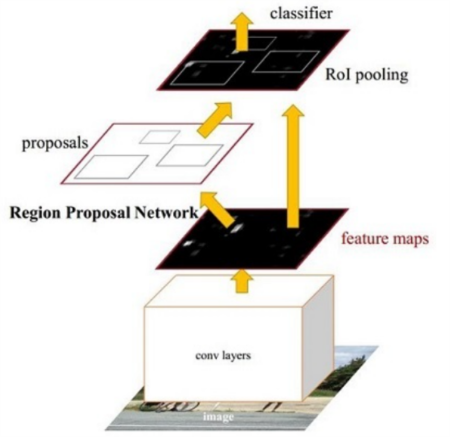

In [5]:
Image("./image/9.png")

• Convolutional layers are used to pick up high-level features from those input images.

• RPN is used to generate and revise the parameters of b-boxes which are highly likely to contain objects.

• RoI pooling is used to match the region proposals generated by RPN with its corresponding features in the feature maps generated by Convolutional layers. Then pooling it in a fixed size to its maximum to extract higher-level feature maps that are going to be classified.

• Classifier is used to identify the categories of all regions of interest and revise the position.

Faster R-CNN is well known as a two-stage model, which is proven more accurate and powerful than the one-stage model in practice. However, the two-stage model can be trained very slowly which is not very satisfying. Furthermore, fully connected layers lead to a large number of parameters to be learned of. And Faster R-CNN performs very badly when it deals with an imbalanced dataset like our dataset, so we made some improvements to our data.

Due to the limitation of memory, the largest batch size of Faster R-CNN is 8. The smaller size of the batch will lead to poor performance. Therefore, we keep the batch size to be 4.

### Introduction of YOLOv5

YOLOv5 is based on CNN neural network architecture. The YOLO detection system first divides the input image into S x S grids, and if the center of an object falls within a grid cell, then this grid cell is responsible for detecting the object. Since we trained the dataset previously which means we pre-processed it, the model predicts only one class based on the latest update. We have deployed pre-trained configurations and weights in the model.[2]

YOLO is implemented as a convolutional neural network, and in summary, the YOLOv5 network structure consists of four main components: input, backbone, neck, and prediction. Depending on the model width and depth, the network models are usually classified as YOLOv5s, YOLOv5m, YOLOv5l, and YOLOv5x. And in this experiment, we used YOLOv5s. It runs faster and is not very demanding on hardware, but the accuracy rate will be lower than the other three.

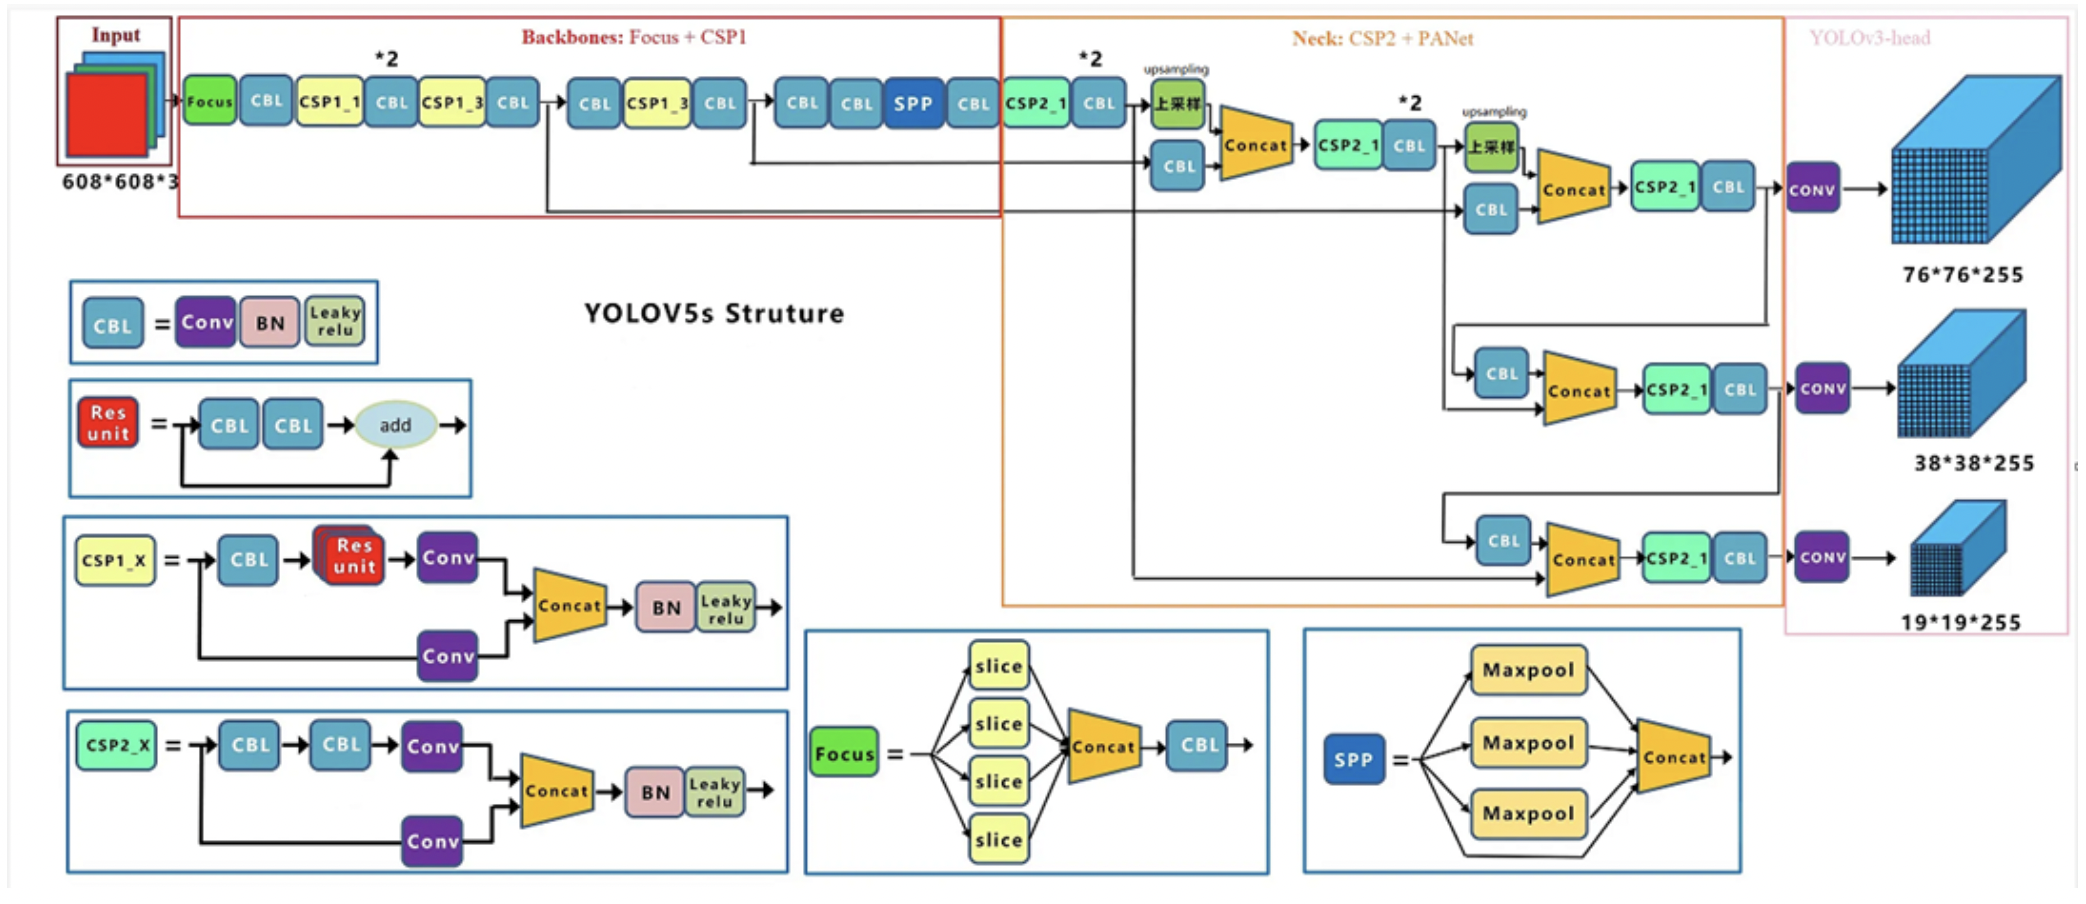

In [3]:
Image("./image/30.png")

## Model

### Training of YOLO

In [23]:
device = '0'
torch.cuda.empty_cache()
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3060 Ti


In [ ]:
!git clone https://github.com/ultralytics/yolov5 

In [19]:
hyp_low_augmentation = """lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)"""
with open("./hyp_low_augmentation.yaml", 'w') as file:
    file.write(hyp_low_augmentation)

1373

In [ ]:
start_time = timer()
!cd ./yolov5&python ./train.py --workers 10 --img 640 --hyp ../hyp_low_augmentation.yaml --batch 16 --epochs 100 --data ../data.yaml --patience 10 --weights ./yolov5s.pt --device {device} --cache
end_time = timer()

In [ ]:
start_time = timer()
!cd ./yolov5&python ./train.py --workers 10 --img 640 --hyp ../hyp_low_augmentation.yaml --batch 16 --epochs 100 --data ../aug_data.yaml --patience 10 --weights ./yolov5s.pt --device {device} --cache
end_time = timer()

### Results of YOLO

#### 100 Epochs of Original Data

The abscissa is the number of epochs, and the ordinate is the index value of specific model evaluation


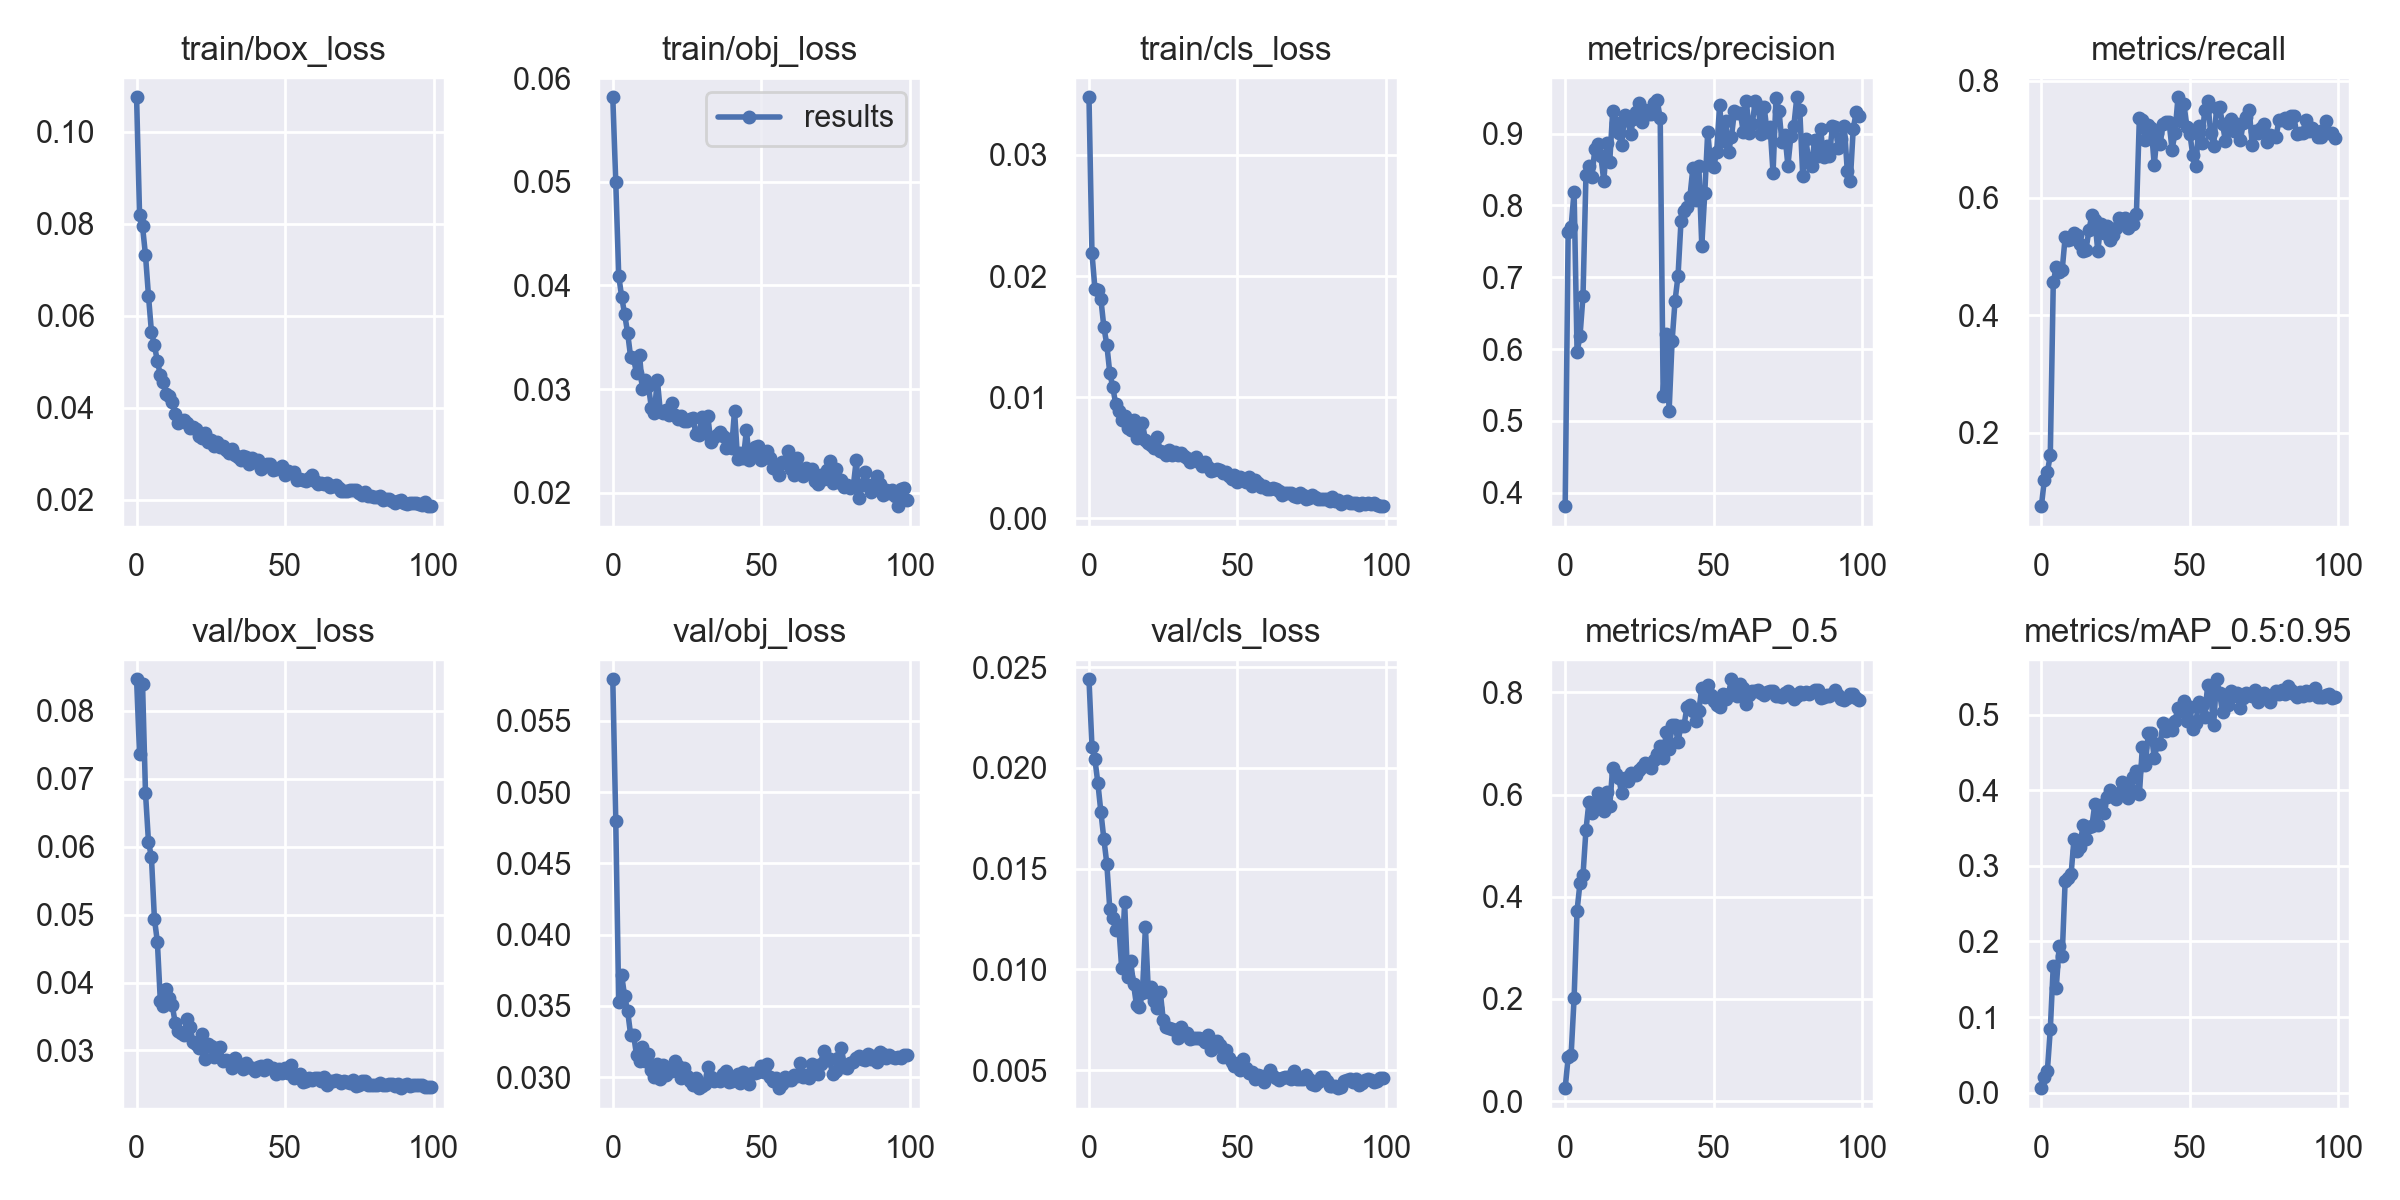

In [60]:
print("The abscissa is the number of epochs, and the ordinate is the index value of specific model evaluation")
Image.open("./yolov5/runs/train/exp6/results.png")

In [55]:
results_origin = pd.read_csv("./yolov5/runs/train/exp6/results.csv")
results_origin.iloc[[99],:]
print("mAP:", results_origin.loc[99,'     metrics/mAP_0.5'])

epoch        train/box_loss        train/obj_loss  \
99                    99               0.01871              0.019255   

          train/cls_loss     metrics/precision        metrics/recall  \
99              0.001041               0.92481                0.7029   

         metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
99               0.78489               0.52422              0.024698   

            val/obj_loss          val/cls_loss                 x/lr0  \
99              0.031523              0.004619              0.000298   

                   x/lr1                 x/lr2  
99              0.000298              0.000298

mAP: 0.78489


#### 100 Epochs of Augmented Data

The abscissa is the number of epochs, and the ordinate is the index value of specific model evaluation


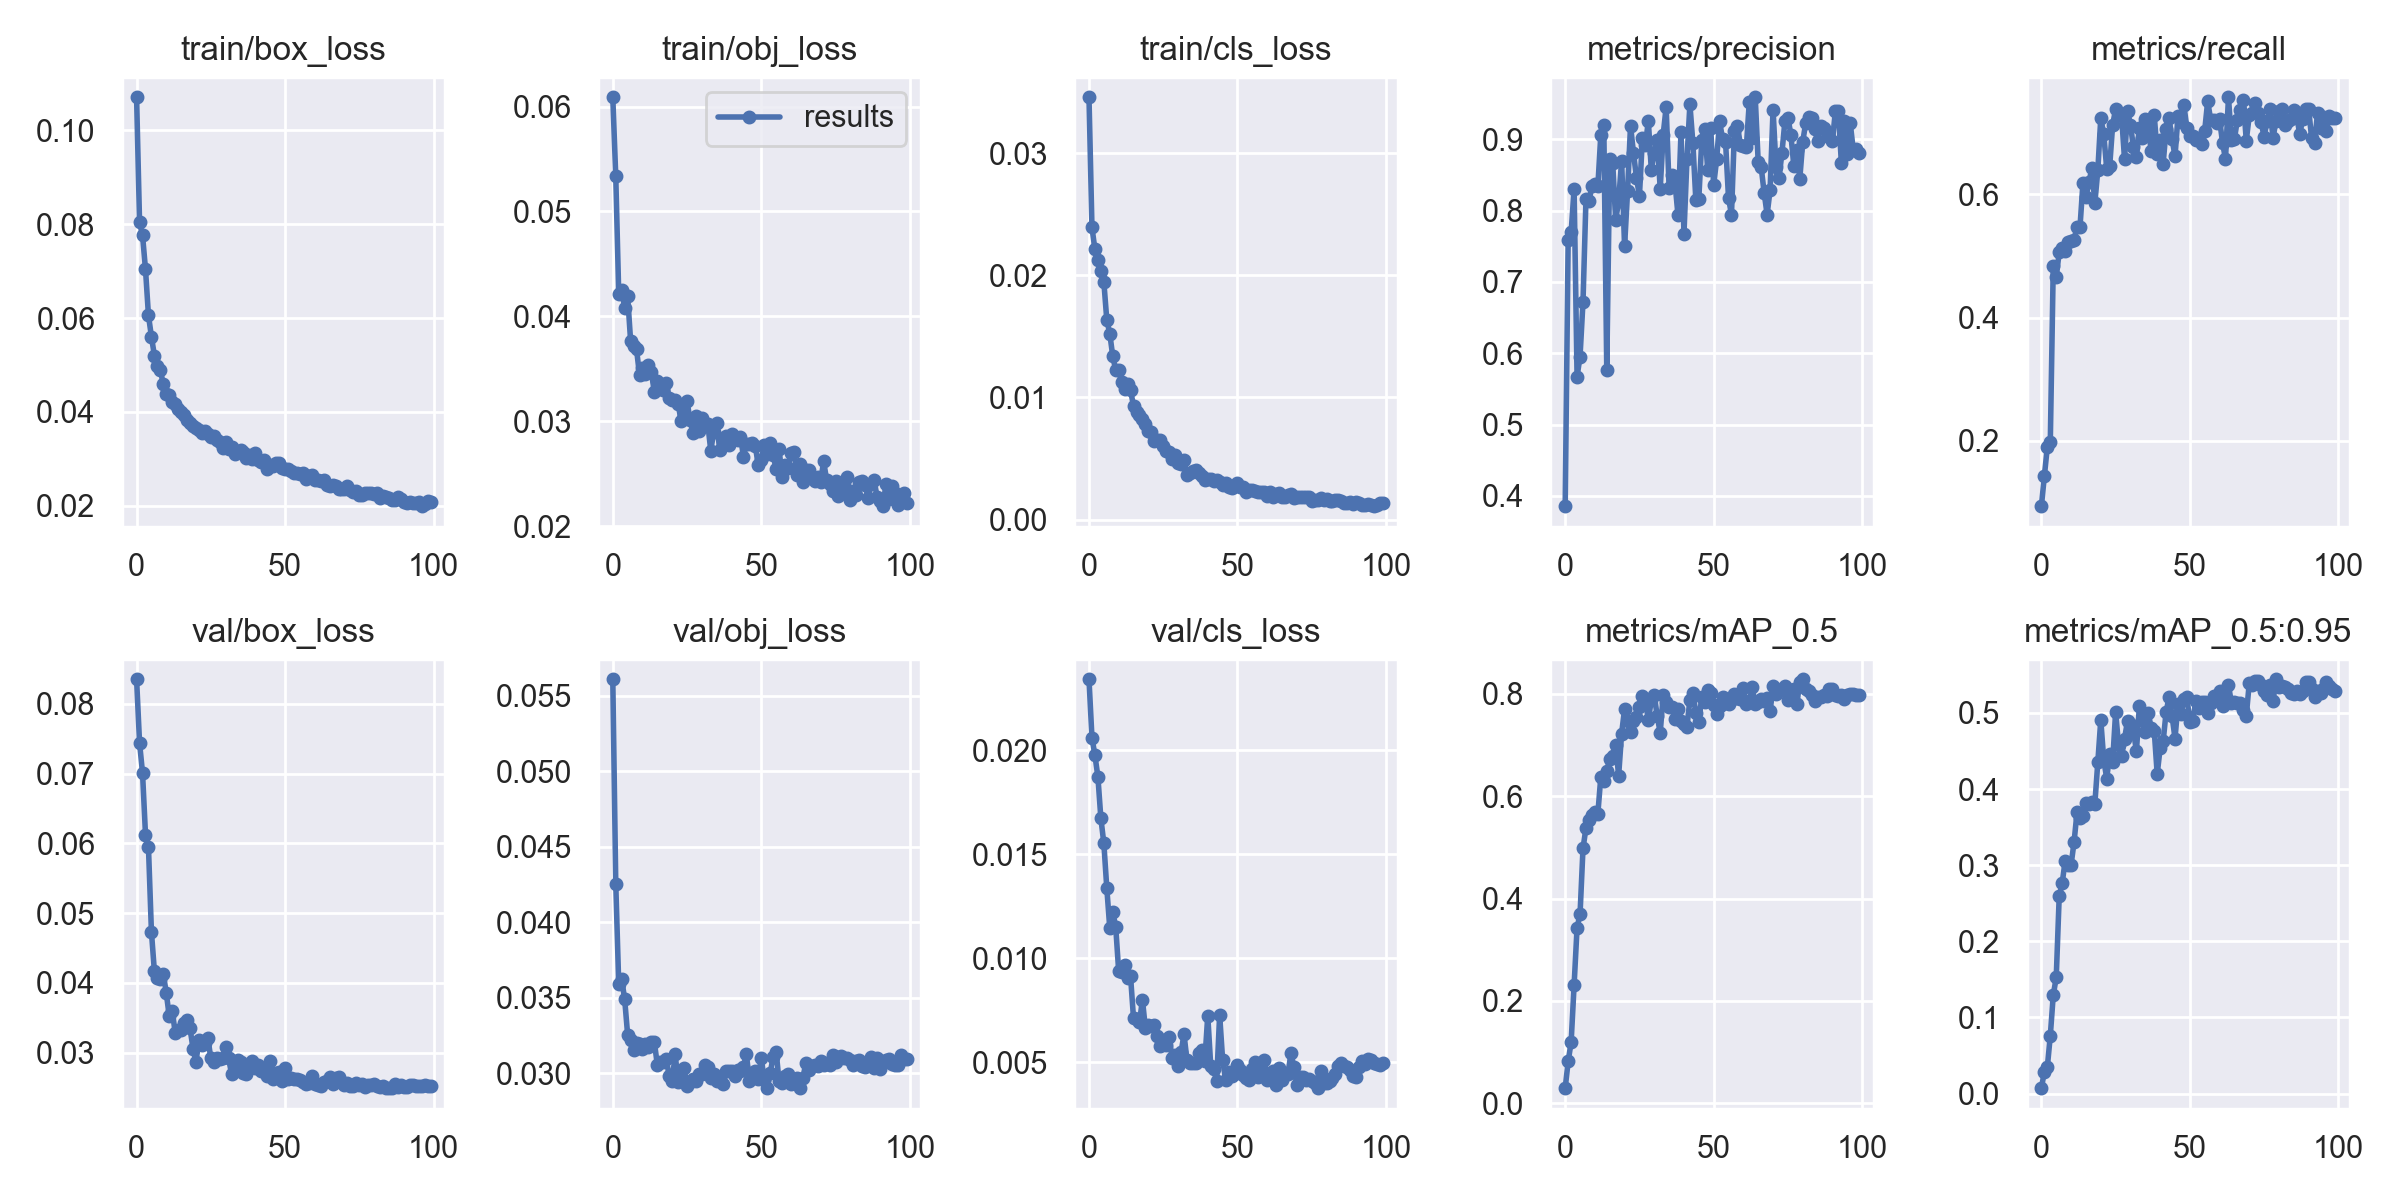

In [61]:
print("The abscissa is the number of epochs, and the ordinate is the index value of specific model evaluation")
Image.open("./yolov5/runs/train/exp7/results.png")

In [56]:
results_augmented = pd.read_csv("./yolov5/runs/train/exp7/results.csv")
results_augmented.iloc[[99],:]
print("mAP:", results_augmented.loc[99,'     metrics/mAP_0.5'])

epoch        train/box_loss        train/obj_loss  \
99                    99              0.020765              0.022236   

          train/cls_loss     metrics/precision        metrics/recall  \
99              0.001321               0.88067               0.72416   

         metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
99               0.79705               0.52875              0.025169   

            val/obj_loss          val/cls_loss                 x/lr0  \
99              0.030955              0.004964              0.000298   

                   x/lr1                 x/lr2  
99              0.000298              0.000298

mAP: 0.79705


### Examples Predicted by YOLOv5 with Enhanced Data Set:

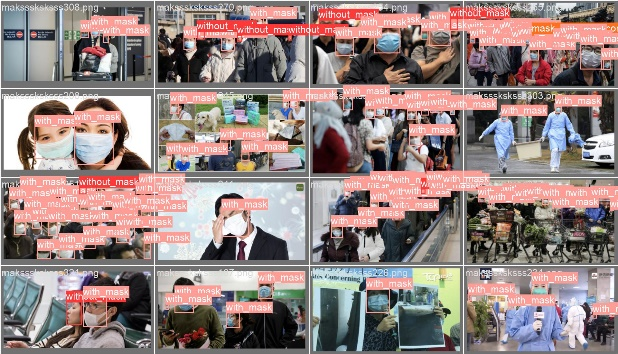

In [5]:
Image("./image/20.png")

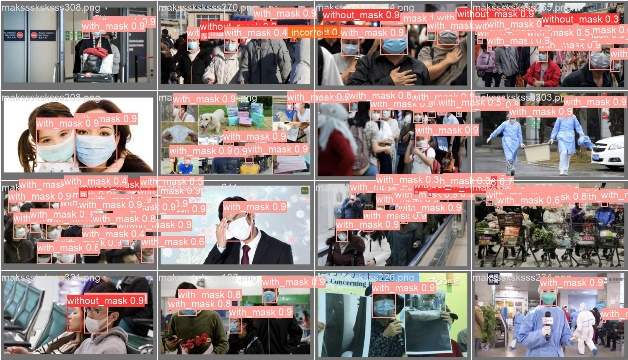

In [6]:
Image("./image/21.png")

### Training of Faster R-CNN

We use the model from [2]

In [ ]:
!git clone https://github.com/bubbliiiing/faster-rcnn-pytorch

In [ ]:
!python ./faster-rcnn-pytorch/voc_annotation.py
!python ./faster-rcnn-pytorch/train.py
# Core params: (Set in model source file)
## weights ./voc_weights_resnet.pth 
## optimizer_type: 'SGD' 
## momentum : 9
## weight_decay: 0.0005
## Init_lr = 1e-2
## lr_decay_type: 'cos'


## The training is divided into two stages: 
### freezing stage and unfreezing stage. 
### The freezing stage is set to meet the training needs of students with insufficient machine performance.

#### Training parameters in freezing stage: Epoches: 0-50
###     Init_Epoch          = 0
###     Freeze_Epoch        = 50
###     Freeze_batch_size   = 8
### At this time, the backbone of the model is frozen, and the feature extraction network does not change
### The video memory occupied is small, and only fine tune the network

#### Training parameters in unfreezing stage: Epoches: 50-150
###   UnFreeze_Epoch = 150，
###   Freeze_batch_size   = 4
### At this time, the backbone of the model is not frozen, and the feature extraction network will change
### The video memory occupied is large, and all network parameters will change

The content of voc_annotation.py is below:

In [ ]:
random.seed(0)
if " " in os.path.abspath(VOCdevkit_path):
    raise ValueError("The path and picture names should not include blank space.")
if annotation_mode == 0 or annotation_mode == 1:
    print("Generate txt in ImageSets.")
    xmlfilepath     = os.path.join(VOCdevkit_path, 'VOC2007/Annotations')
    saveBasePath    = os.path.join(VOCdevkit_path, 'VOC2007/ImageSets/Main')
    temp_xml        = os.listdir(xmlfilepath)
    total_xml       = []
    for xml in temp_xml:
        if xml.endswith(".xml"):
            total_xml.append(xml)

    num     = len(total_xml)  
    list    = range(num)  
    tv      = int(num*trainval_percent)  
    tr      = int(tv*train_percent)  
    trainval= random.sample(list,tv)  
    train   = random.sample(trainval,tr)  

    print("train and val size",tv)
    print("train size",tr)
    ftrainval   = open(os.path.join(saveBasePath,'trainval.txt'), 'w')  
    ftest       = open(os.path.join(saveBasePath,'test.txt'), 'w')  
    ftrain      = open(os.path.join(saveBasePath,'train.txt'), 'w')  
    fval        = open(os.path.join(saveBasePath,'val.txt'), 'w')  

    for i in list:  
        name=total_xml[i][:-4]+'\n'  
        if i in trainval:  
            ftrainval.write(name)  
            if i in train:  
                ftrain.write(name)  
            else:  
                fval.write(name)  
        else:  
            ftest.write(name)  

    ftrainval.close()  
    ftrain.close()  
    fval.close()  
    ftest.close()
    print("Generate txt in ImageSets done.")

if annotation_mode == 0 or annotation_mode == 2:
    print("Generate 2007_train.txt and 2007_val.txt for train.")
    type_index = 0
    for year, image_set in VOCdevkit_sets:
        image_ids = open(os.path.join(VOCdevkit_path, 'VOC%s/ImageSets/Main/%s.txt'%(year, image_set)), encoding='utf-8').read().strip().split()
        list_file = open('%s_%s.txt'%(year, image_set), 'w', encoding='utf-8')
        for image_id in image_ids:
            list_file.write('%s/VOC%s/JPEGImages/%s.jpg'%(os.path.abspath(VOCdevkit_path), year, image_id))

            convert_annotation(year, image_id, list_file)
            list_file.write('\n')
        photo_nums[type_index] = len(image_ids)
        type_index += 1
        list_file.close()
    print("Generate 2007_train.txt and 2007_val.txt for train done.")

    def printTable(List1, List2):
        for i in range(len(List1[0])):
            print("|", end=' ')
            for j in range(len(List1)):
                print(List1[j][i].rjust(int(List2[j])), end=' ')
                print("|", end=' ')
            print()

    str_nums = [str(int(x)) for x in nums]
    tableData = [
        classes, str_nums
    ]
    colWidths = [0]*len(tableData)
    len1 = 0
    for i in range(len(tableData)):
        for j in range(len(tableData[i])):
            if len(tableData[i][j]) > colWidths[i]:
                colWidths[i] = len(tableData[i][j])
    printTable(tableData, colWidths)

The content of train.py is below:

In [ ]:
model = FasterRCNN(num_classes, anchor_scales = anchors_size, backbone = backbone, pretrained = pretrained)
if not pretrained:
    weights_init(model)
if model_path != '':
    #------------------------------------------------------#
    #   models path is set in advance
    #------------------------------------------------------#
    print('Load weights {}.'.format(model_path))
    device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_dict      = model.state_dict()
    pretrained_dict = torch.load(model_path, map_location = device)
    load_key, no_load_key, temp_dict = [], [], {}
    for k, v in pretrained_dict.items():
        if k in model_dict.keys() and np.shape(model_dict[k]) == np.shape(v):
            temp_dict[k] = v
            load_key.append(k)
        else:
            no_load_key.append(k)
    model_dict.update(temp_dict)
    model.load_state_dict(model_dict)
    #------------------------------------------------------#
    #   Showing key which is not matched
    #------------------------------------------------------#
    print("\nSuccessful Load Key:", str(load_key)[:500], "……\nSuccessful Load Key Num:", len(load_key))
    print("\nFail To Load Key:", str(no_load_key)[:500], "……\nFail To Load Key num:", len(no_load_key))
    print("\n\033[1;33;44m，it is common without head but not without Backbone。\033[0m")

#----------------------#
#   Record Loss
#----------------------#
time_str        = datetime.datetime.strftime(datetime.datetime.now(),'%Y_%m_%d_%H_%M_%S')
log_dir         = os.path.join(save_dir, "loss_" + str(time_str))
loss_history    = LossHistory(log_dir, model, input_shape=input_shape)

#------------------------------------------------------------------#
#   Please uss torch 1.7.1 and above
#------------------------------------------------------------------#
if fp16:
    from torch.cuda.amp import GradScaler as GradScaler
    scaler = GradScaler()
else:
    scaler = None

model_train     = model.train()
if Cuda:
    model_train = torch.nn.DataParallel(model_train)
    cudnn.benchmark = True
    model_train = model_train.cuda()

#---------------------------#
#   Fetch corresponding txt
#---------------------------#
with open(train_annotation_path, encoding='utf-8') as f:
    train_lines = f.readlines()
with open(val_annotation_path, encoding='utf-8') as f:
    val_lines   = f.readlines()
num_train   = len(train_lines)
num_val     = len(val_lines)

show_config(
    classes_path = classes_path, model_path = model_path, input_shape = input_shape, \
    Init_Epoch = Init_Epoch, Freeze_Epoch = Freeze_Epoch, UnFreeze_Epoch = UnFreeze_Epoch, Freeze_batch_size = Freeze_batch_size, Unfreeze_batch_size = Unfreeze_batch_size, Freeze_Train = Freeze_Train, \
    Init_lr = Init_lr, Min_lr = Min_lr, optimizer_type = optimizer_type, momentum = momentum, lr_decay_type = lr_decay_type, \
    save_period = save_period, save_dir = save_dir, num_workers = num_workers, num_train = num_train, num_val = num_val
)
wanted_step = 5e4 if optimizer_type == "sgd" else 1.5e4
total_step  = num_train // Unfreeze_batch_size * UnFreeze_Epoch
if total_step <= wanted_step:
    if num_train // Unfreeze_batch_size == 0:
        raise ValueError('Data set is too small.')
    wanted_epoch = wanted_step // (num_train // Unfreeze_batch_size) + 1
    print("\n\033[1;33;44m[Warning] When using %s, please set batch size above %d。\033[0m"%(optimizer_type, wanted_step))
    print("\033[1;33;44m[Warning] The total number of data is %d，Unfreeze_batch_size is %d，and %d Epoch，batch size is %d。\033[0m"%(num_train, Unfreeze_batch_size, UnFreeze_Epoch, total_step))
    print("\033[1;33;44m[Warning] Because batch size is %d，less than %d，please set the total epoch as %d。\033[0m"%(total_step, wanted_step, wanted_epoch))

#------------------------------------------------------#
#   Freezing training can fasten the training speed
#------------------------------------------------------#
if True:
    UnFreeze_flag = False
    #------------------------------------#
    #   Freeze one part of training
    #------------------------------------#
    if Freeze_Train:
        for param in model.extractor.parameters():
            param.requires_grad = False
    # ------------------------------------#
    #   Freeze bn layer
    # ------------------------------------#
    model.freeze_bn()

    #-------------------------------------------------------------------#
    #   If training is not freezed, please set batch_size as Unfreeze_batch_size
    #-------------------------------------------------------------------#
    batch_size = Freeze_batch_size if Freeze_Train else Unfreeze_batch_size

    #-------------------------------------------------------------------#
    #   Adjust learning rate according to current batch_size
    #-------------------------------------------------------------------#
    nbs             = 16
    lr_limit_max    = 1e-4 if optimizer_type == 'adam' else 5e-2
    lr_limit_min    = 1e-4 if optimizer_type == 'adam' else 5e-4
    Init_lr_fit     = min(max(batch_size / nbs * Init_lr, lr_limit_min), lr_limit_max)
    Min_lr_fit      = min(max(batch_size / nbs * Min_lr, lr_limit_min * 1e-2), lr_limit_max * 1e-2)

    #---------------------------------------#
    #   Choose optimizer according to optimizer_type
    #---------------------------------------#
    optimizer = {
        'adam'  : optim.Adam(model.parameters(), Init_lr_fit, betas = (momentum, 0.999), weight_decay = weight_decay),
        'sgd'   : optim.SGD(model.parameters(), Init_lr_fit, momentum = momentum, nesterov=True, weight_decay = weight_decay)
    }[optimizer_type]

    #---------------------------------------#
    #   Gaining formula of decreasing of learning rate
    #---------------------------------------#
    lr_scheduler_func = get_lr_scheduler(lr_decay_type, Init_lr_fit, Min_lr_fit, UnFreeze_Epoch)

    #---------------------------------------#
    #   Determining the length of every epoch
    #---------------------------------------#
    epoch_step      = num_train // batch_size
    epoch_step_val  = num_val // batch_size

    if epoch_step == 0 or epoch_step_val == 0:
        raise ValueError("Data set is too small.")

    train_dataset   = FRCNNDataset(train_lines, input_shape, train = True)
    val_dataset     = FRCNNDataset(val_lines, input_shape, train = False)

    gen             = DataLoader(train_dataset, shuffle = True, batch_size = batch_size, num_workers = num_workers, pin_memory=True,
                                drop_last=True, collate_fn=frcnn_dataset_collate)
    gen_val         = DataLoader(val_dataset  , shuffle = True, batch_size = batch_size, num_workers = num_workers, pin_memory=True, 
                                drop_last=True, collate_fn=frcnn_dataset_collate)

    train_util      = FasterRCNNTrainer(model_train, optimizer)
    #----------------------#
    #   Record map curve of eval
    #----------------------#
    eval_callback   = EvalCallback(model_train, input_shape, class_names, num_classes, val_lines, log_dir, Cuda, \
                                    eval_flag=eval_flag, period=eval_period)

    #---------------------------------------#
    #   Start model training
    #---------------------------------------#
    for epoch in range(Init_Epoch, UnFreeze_Epoch):
        #---------------------------------------#
        #   If there is one part of freezing learning
        #   then unfreeze and set parameters
        #---------------------------------------#
        if epoch >= Freeze_Epoch and not UnFreeze_flag and Freeze_Train:
            batch_size = Unfreeze_batch_size

            #-------------------------------------------------------------------#
            #   Adjust learning rate according to current batch_size
            #-------------------------------------------------------------------#
            nbs             = 16
            lr_limit_max    = 1e-4 if optimizer_type == 'adam' else 5e-2
            lr_limit_min    = 1e-4 if optimizer_type == 'adam' else 5e-4
            Init_lr_fit     = min(max(batch_size / nbs * Init_lr, lr_limit_min), lr_limit_max)
            Min_lr_fit      = min(max(batch_size / nbs * Min_lr, lr_limit_min * 1e-2), lr_limit_max * 1e-2)
            #---------------------------------------#
            #   Gaining formula of decreasing of learning rate
            #---------------------------------------#
            lr_scheduler_func = get_lr_scheduler(lr_decay_type, Init_lr_fit, Min_lr_fit, UnFreeze_Epoch)

            for param in model.extractor.parameters():
                param.requires_grad = True
            # ------------------------------------#
            #   Freeze bn layer
            # ------------------------------------#
            model.freeze_bn()

            epoch_step      = num_train // batch_size
            epoch_step_val  = num_val // batch_size

            if epoch_step == 0 or epoch_step_val == 0:
                raise ValueError("Data set is too small.")

            gen             = DataLoader(train_dataset, shuffle = True, batch_size = batch_size, num_workers = num_workers, pin_memory=True,
                                        drop_last=True, collate_fn=frcnn_dataset_collate)
            gen_val         = DataLoader(val_dataset  , shuffle = True, batch_size = batch_size, num_workers = num_workers, pin_memory=True, 
                                        drop_last=True, collate_fn=frcnn_dataset_collate)

            UnFreeze_flag = True

        set_optimizer_lr(optimizer, lr_scheduler_func, epoch)

        fit_one_epoch(model, train_util, loss_history, eval_callback, optimizer, epoch, epoch_step, epoch_step_val, gen, gen_val, UnFreeze_Epoch, Cuda, fp16, scaler, save_period, save_dir)

    loss_history.writer.close()

Then we start to train our model

In [ ]:
!python ./faster-rcnn-pytorch/train.py
# Core params: (Set in model source file)
## weights ./voc_weights_resnet.pth 
## optimizer_type: 'SGD' 
## momentum : 9
## weight_decay: 0.0005
## Init_lr = 1e-2
## lr_decay_type: 'cos'


## The training is divided into two stages: 
### freezing stage and unfreezing stage. 
### The freezing stage is set to meet the training needs of students with insufficient machine performance.

#### Training parameters in freezing stage: Epoches: 0-50
###     Init_Epoch          = 0
###     Freeze_Epoch        = 50
###     Freeze_batch_size   = 8
### At this time, the backbone of the model is frozen, and the feature extraction network does not change
### The video memory occupied is small, and only fine tune the network

#### Training parameters in unfreezing stage: Epoches: 50-150
###   UnFreeze_Epoch = 150，
###   Freeze_batch_size   = 4
### At this time, the backbone of the model is not frozen, and the feature extraction network will change
### The video memory occupied is large, and all network parameters will change

### Result of Faster R-CNN

#### 180 Epochs of Original Data

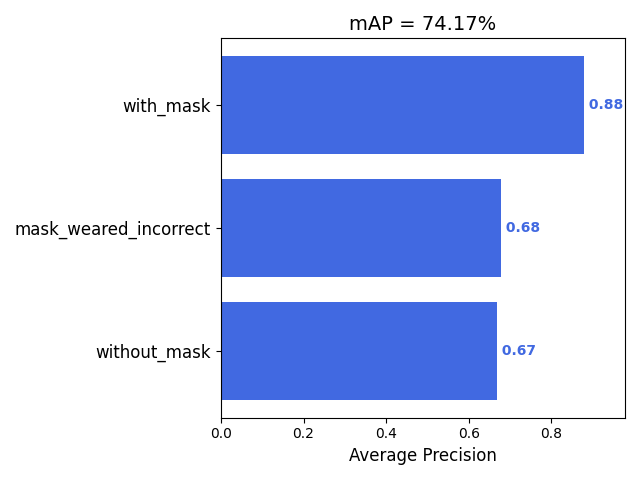

In [63]:
Image.open("./faster-rcnn-pytorch/original_data_map_out_frcnn/map_out/results/mAP.png")

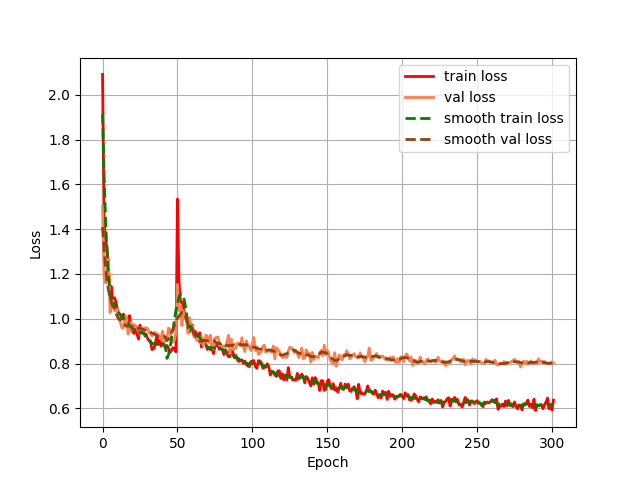

In [6]:
Image("./image/11.png")

#### 300 Epochs of Augmented Data

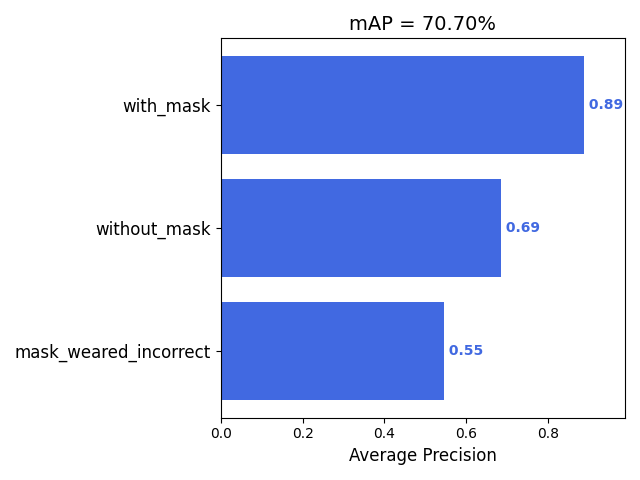

In [64]:
Image.open("./faster-rcnn-pytorch/aug_data_map_out_frcnn_more_batchsize/map_out/results/mAP.png")

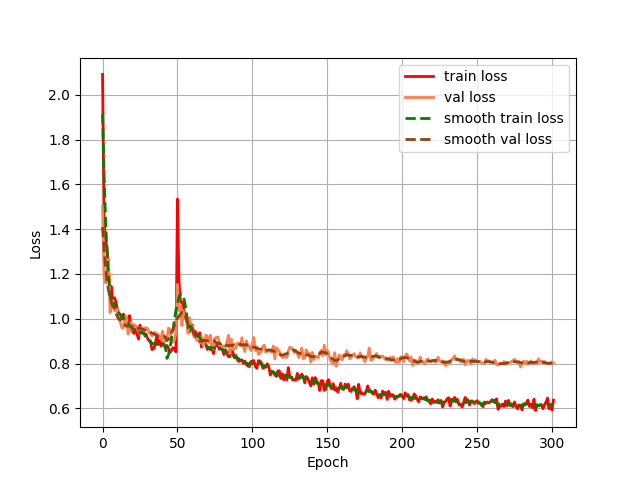

In [7]:
Image("./image/11.png")

We can observe that the training loss finally went down to 0.6 and the val loss to 0.8, and the average precision is about 0.7. Which is almost the same as the original data set. But there are several slight differences. The changes of loss and map of enhanced data set are more stable with less sharp curves.

Also, the improvement of the prediction of a category called mask_wear_incorrect saw a great increase after rather fewer epochs. So what we did to the original data set is really a good move and received a satisfying result. This also indicates that there may be some problems with our data set and we will discuss it later.

#### Examples Predicted by Model with Enhanced Data Set: 

(The green boxes are ground truth and blue boxes are predicted)

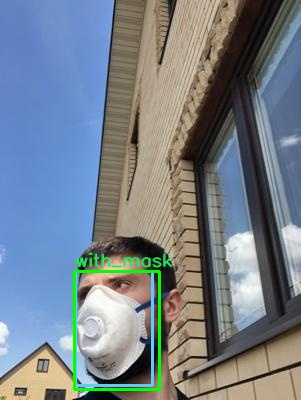

In [10]:
Image("./image/12.png")

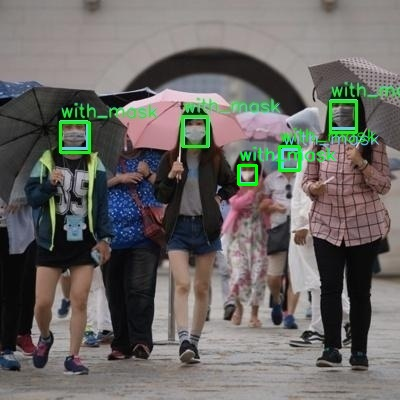

In [11]:
Image("./image/13.png")

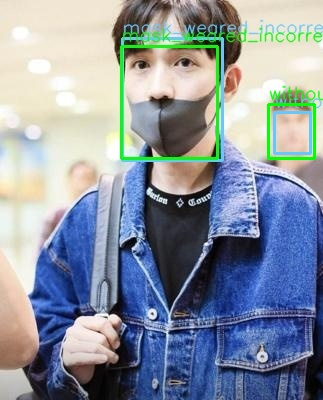

In [12]:
Image("./image/14.png")

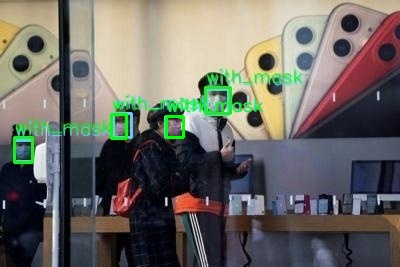

In [9]:
Image("./image/15.png")

We can clearly see that in most situations, the trained model can correctly predict people with mask, without mask or wearing incorrect mask. Especially in the field of with mask, our model behaves best and the accuracy rate nearly reaches 90%. From those pictures, we could also see that the coverage of ground truth and predicting box are almost the same. This also indicates that Faster R-CNN shows its abilities in object prediction.

However, we also observed some bad performances, particularly in the other two categories. Here are some example pictures below:

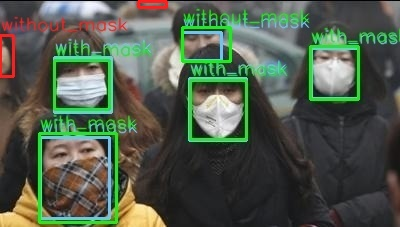

In [13]:
Image("./image/16.png")

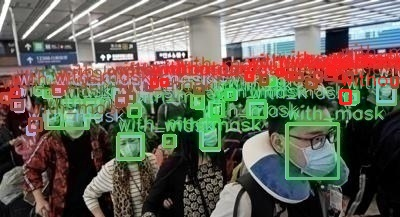

In [14]:
Image("./image/17.png")

The red boxes are the wrong ones which are not given as our ground truth.
We could observe that most wrong boxes belong to the classes which are without mask and with incorrect mask. There may exist some reasons.
Firstly, it is clear that our data set is not balanced. From the picture given below, which shows the ground truth of three categories, we can see that there are too less samples of “mask_wear_incorrect”. The lacking of training materials can lead to significant consequences, and we have already proven that our model worked so bad in this field.


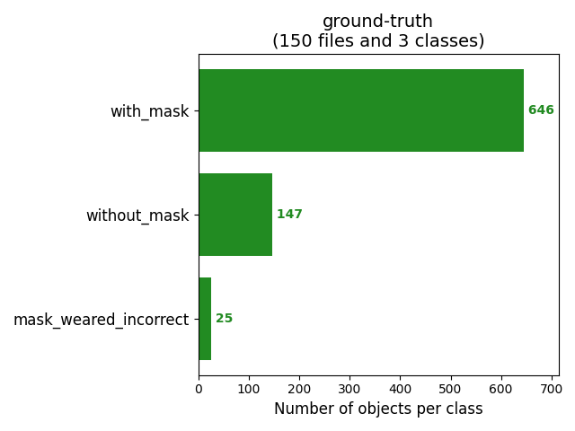

In [3]:
Image("./image/18.png")

Secondly, due to the time limit, we have not made enough improvements to our code but only changed some of its parameters like batch size and maximum epochs. However, these explorations didn’t return very satisfying feedback. Maybe in the long run we could learn more about its structure and make some changes to improve its efficiency.

However,  something may go wrong with the Judgment indicator or the ground truth.
Like the picture below:


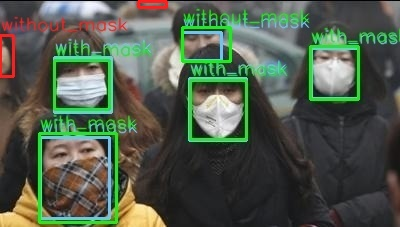

In [4]:
Image("./image/19.png")

The red box on the leftmost side should be correct but it is not recorded in our ground truth so our marking criterion of MAP regarded it as a wrong one. But actually, Faster R-CNN behaved much better than we expected. It not only correctly recognized the human face with only less than half of it shown in the picture but also made the right judgement that this girl does not wear a mask. In this case, we can be more optimistic that our accuracy rate is higher than given.

## Discussion

In this project, we used some deep learning methods to challenge an object detection task. Two models called YOLO and Faster R-CNN are demonstrated in our project. Based on the values of our sheets and the outputs shown above, the first one-stage model YOLO model has better performance than the two-stage model Faster R-CNN.


It is clear that YOLO has less training time and gains more precise results. Hence, it can be concluded that YOLO is indeed a time-efficient and well-performed model.


In addition, we enhanced our data set and expanded two classes of without_mask and mask_wear_incorrect which slightly increase the performance of our models.


Due to the limitation of time, there are still some insignificance and shortages that could be improved. And the influence of different batch sizes and learning rates could be discussed more. Moreover, we do not have enough time to try any other new advanced models like Swin Transformer. In recent years these new models are playing more and more significant roles in the object detection aspect. Hoping we could have other chances to try all of these interesting models in the near future. 

## Reference

1. Howard, J., Huang, A., Li, Z., Tufekci, Z., Zdimal, V., Westhuizen, H.-M. van der, … Rimoin, A. W. (2021). An evidence review of face masks against COVID-19. PNAS, 118. https://doi.org/118 (4) e2014564118

2. S. Ren, K. He, R. Girshick, and J. Sun, “Faster r-cnn: Towards real-time object detection with region proposal networks,” 2016.

3. Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. . (2016). You only look once: unified, real-time object detection.

4. Jiang, P, Ergu, D, Liu, F, Cai, Y & Ma, B 2022, ‘A Review of Yolo Algorithm Developments’, Procedia computer science, vol. 199, pp. 1066–1073.

5. Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi; Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 779-788.

6. https://github.com/bubbliiiing/faster-rcnn-pytorch

7. https://github.com/ultralytics/yolov5
